In [21]:
import pdb
import argparse
import cv2
import numpy as np
import torch
from torch.autograd import Function
from torchvision import models
import matplotlib.pyplot as plt


## For BSN
class FeatureExtractor():
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers """

    def __init__(self, model):
        self.model = model
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        
        
        
        
        outputs = []
        self.gradients = []
        
        
        ipret_rep = self.model.embedding_encoder(x)
        
        ipret_rep.register_hook(self.save_gradient)

        outputs += [ipret_rep]
        
        pred_out = self.model.ipret_clasifier(ipret_rep)
        
        return outputs, pred_out
        
        
    
    
    
        


class ModelOutputs():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers. """

    def __init__(self, model):
        self.model = model
        self.feature_extractor = FeatureExtractor(self.model)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations, output = self.feature_extractor(x)
        return target_activations, output


class GradCam:
    def __init__(self, model, num_ch,use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        self.num_channels = num_ch
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()
        
       
        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        
        
        
        weights = grads_val[0,:] ## will be shape (3,39)
        #pdb.set_trace()
        
        #weights = np.transpose(weights,(1,0))## will be shape (39,3)


        #target = np.transpose(target,(1,0)) ## will be shape (39,3)
        
        cam = np.zeros(target.shape, dtype=np.float32) ## will be shape (39,3)
        
        for ch_id in range(target.shape[0]):
            cam[ch_id] += abs(weights[ch_id])# * target[ch_id]
            

        cam = np.maximum(cam, 0)
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam, index




In [22]:
import os
import PIL
import numpy as np
import torch
import sys
import pickle
from lime_helpers import * 


In [43]:
img_size = 224
batch_size = 1



#dataset_name = str(sys.argv[1]) #"cycif" "cytometry"
#backbone_method = str(sys.argv[2]) #'resnet3d' or #'resnet18'
#embedding_method = str(sys.argv[3]) #'shared' or #'channel-wise'
#class_method = str(sys.argv[4])#'gap' or #'fc'

dataset_name = "synthetic" 
# dataset_name = "cycif" 
# dataset_name = "cytometry" 
backbone_method = "resnet18"
# backbone_method = "resnet3d" 
# embedding_method = "shared" 
embedding_method = "channel-wise" 
class_method = 'fc'



if dataset_name=="cytometry":
    from cytometrydataloader import BioformatTiffreader, DataPreparation
    
if dataset_name=="cycif":
    from cycifdataloader import BioformatTiffreader, DataPreparation
        
if dataset_name == 'synthetic':
    from syntheticdataloader import SyntheticData
    gt_type_arg = "class"
    num_classes = 3
    
from ablationmodels import ImageClassificationModel

model_path = get_model_path(dataset_name,backbone_method,embedding_method,class_method)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


model = torch.load(model_path)
model = model.to(device)

metadata = get_datasets_dict(dataset_name,metadataOnly=True)

num_channels = metadata["num_channels"]
num_classes = metadata["num_classes"]
gt_type_arg = metadata["gt_type_arg"]

if dataset_name!='synthetic':
    with open('./prepared_data_files/prepared_data_{}.pkl'.format(gt_type_arg), 'rb') as pkl_file:
        prepared_data = pickle.load(pkl_file)
    dataset_test = BioformatTiffreader(prepared_data,
                                       img_size=img_size,
                                       phase_str='test')
    dataset_loader = torch.utils.data.DataLoader(dataset=dataset_test,
                                                 batch_size=batch_size,
                                                 shuffle=False,
                                                 drop_last=False,
                                                 num_workers=8)
else:
    dataset_test = SyntheticData(num_images=300,
                                 phase='test')
    dataset_loader = torch.utils.data.DataLoader(dataset=dataset_test,
                                                     batch_size=batch_size,
                                                     shuffle=False,
                                                     drop_last=False,
                                                     num_workers=8)



model = torch.load(model_path)
model = model.to(device)
model.eval()

./best_models_roi/best_model_16_synthetic_method_resnet18_channel-wise_fc_gttype_class_lr_0001.pt
GT: 0 associated with : [(9, 'right', {'low': 0.19, 'high': 0.71}), (3, 'right', {'low': 0.27, 'high': 0.64})]
GT: 1 associated with : [(4, 'right', {'low': 0.31, 'high': 0.62}), (18, 'right', {'low': 0.36, 'high': 0.86})]
GT: 2 associated with : [(19, 'right', {'low': 0.19, 'high': 0.82}), (15, 'right', {'low': 0.12, 'high': 0.82})]
loaded dataset.


ImageClassificationModel(
  (embedding_encoder): EmbeddingEncoder(
    (backbone_convs): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

True

18: 260.625
19: 191.782
15: 127.852
4: 123.820
9: 104.655
14: 101.586
13: 88.156
6: 82.119
11: 78.858
20: 78.424
10: 78.292
7: 77.607
27: 72.709
29: 66.325
5: 65.900
8: 62.632
12: 60.314
21: 55.567
16: 54.693
26: 49.333
22: 46.814
23: 43.121
0: 42.957
17: 38.848
2: 37.769
3: 33.952
28: 31.789
24: 29.237
1: 24.957
25: 19.076


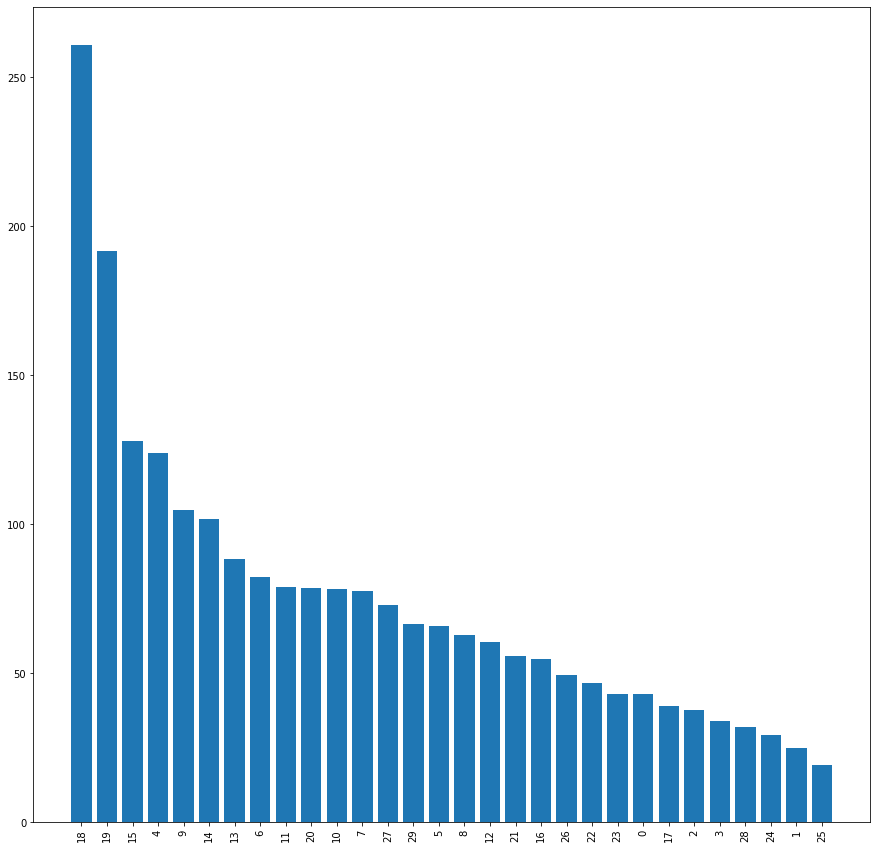

In [44]:
grad_cam = GradCam(model=model, num_ch=num_channels,use_cuda=True)


target_index = None

channel_importances = np.zeros(num_channels)
class_importances = np.zeros((num_classes, num_channels))

for inputs, labels in dataset_loader:
    
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    feat = model.embedding_encoder(inputs)
#     out = model.ipret_clasifier(feat)
#     v, i = out.max(1)
#     i = i.cpu().data.numpy()[0]
#     print(i, labels.cpu().data.numpy()[0])
#     channel_importances += np.mean(np.abs(feat.cpu().data.numpy()[0]), 1)
#     channel_importances += feat.cpu().data.numpy()[0, :, i]
    
    mask, index = grad_cam(inputs, target_index)
    ## mask shape is (39,3)
#     if class_method == "fc":
    channel_importances += mask
    class_importances[index] += mask
#     if class_method == "gap":
#         channel_importances += np.mean(mask, axis=1)

# Aggregated Importance
if dataset_name == 'synthetic':
    valid_channelList = [{'channel_name': str(channel_id)} for channel_id in range(num_channels)]
else:
    valid_channelList = prepared_data.valid_channelList
channel_ranking = np.argsort(-channel_importances) # Decrease
res_dict = {'channel_names': [], 'channel_importances': []}
for channel_id in channel_ranking:
    print('{}: {:.3f}'.format(valid_channelList[channel_id]['channel_name'], channel_importances[channel_id]))
    res_dict['channel_names'].append(valid_channelList[channel_id]['channel_name']) 
    res_dict['channel_importances'].append(channel_importances[channel_id]) 
with open('interpretation/{}-{}-{}-{}.pkl'.format(dataset_name, backbone_method, embedding_method, 'backprop'), 'wb') as pickle_file:
    pickle.dump(res_dict, pickle_file)

plt.figure('fig_size', (15, 15))
plt.bar(res_dict['channel_names'], res_dict['channel_importances'])
plt.xticks(rotation=90)
plt.savefig('interpretation/{}-{}-{}-{}.pdf'.format(dataset_name, backbone_method, embedding_method, 'backprop'))
plt.show()
plt.close()

# # Per class Importance
# class_names = ['PRE', 'ON', 'POST'] if dataset_name == 'cycif' else ['Grade1', 'Grade2', 'Grade3']
# for class_id, channel_importances in enumerate(class_importances):
#     channel_ranking = np.argsort(-channel_importances) # Decrease
#     res_dict = {'channel_names': [], 'channel_importances': []}
#     for channel_id in channel_ranking:
#         print('{}: {:.3f}'.format(valid_channelList[channel_id]['channel_name'], channel_importances[channel_id]))
#         res_dict['channel_names'].append(valid_channelList[channel_id]['channel_name']) 
#         res_dict['channel_importances'].append(channel_importances[channel_id]) 
#     with open('interpretation/{}-{}-{}-{}-{}.pkl'.format(dataset_name, 
#                                                          backbone_method, 
#                                                          embedding_method, 
#                                                          'backprop',
#                                                          class_names[class_id]), 'wb') as pickle_file:
#         pickle.dump(res_dict, pickle_file)

#     plt.figure('fig_size', (15, 15))
#     plt.bar(res_dict['channel_names'], res_dict['channel_importances'])
#     plt.xticks(rotation=90)
#     plt.savefig('interpretation/{}-{}-{}-{}-{}.pdf'.format(dataset_name, 
#                                                            backbone_method, 
#                                                            embedding_method, 
#                                                            'backprop',
#                                                            class_names[class_id]))
#     plt.show()
#     plt.close()

In [ ]:
3,4,9,15,18,19

In [50]:
dataset_name = 'cytometry' # 'cycif' # cytometry
backbone_method = 'resnet3d' # 'resnet3d' # resnet18
embedding_method = 'shared' # 'channel-wise' # 'shared'
with open('interpretation/{}-{}-{}-{}.pkl'.format(dataset_name, backbone_method, embedding_method, 'backprop'), 'rb') as pickle_file:
    res_dict = pickle.load(pickle_file)

plt.figure('fig_size', (15, 15))
plt.bar(res_dict['channel_names'], res_dict['channel_importances'])
plt.xticks(rotation=90, ha="right")
plt.savefig('interpretation/{}-{}-{}-{}.pdf'.format(dataset_name, backbone_method, embedding_method, 'backprop'))
plt.show()
plt.close()



# fig = plt.figure('fig_size', (20, 10))
# ax = fig.add_axes([0.15, 0.15, 0.70, 0.70])

# # rects1 = ax.bar(x - width, marker_perGrade[1]['values'], width, label='Grade 1')
# # rects2 = ax.bar(x, marker_perGrade[2]['values'], width, label='Grade 2')
# # rects3 = ax.bar(x + width, marker_perGrade[3]['values'], width, label='Grade 3')

# # g1 = np.asarray(marker_perGrade[1]['values'][:38] + marker_perGrade[1]['values'][38+1:53])
# # g1_denom = g1 + 1e-7
# # g2 = marker_perGrade[2]['values'][:38] + marker_perGrade[2]['values'][38+1:53]
# # g3 = marker_perGrade[3]['values'][:38] + marker_perGrade[3]['values'][38+1:53]
# # rects1 = ax.bar(x - width, g1/g1_denom, width, label='Grade 1')
# # rects2 = ax.bar(x,         g2/g1_denom, width, label='Grade 2')
# # rects3 = ax.bar(x + width, g3/g1_denom, width, label='Grade 3')

# # rects1 = ax.bar()

# ax.set_ylabel('Average')
# ax.set_title('Average marker intensity of each grade label')
# ax.set_xticks(x)
# ax.set_xticklabels(marker_perGrade[1]['name'][:38] + marker_perGrade[1]['name'][38+1:53])
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")
# ax.legend()

# # fig.tight_layout()
# plt.savefig('avg_marker_per_grade.pdf')

# plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'interpretation/cytometry-resnet3d-shared-backprop.pkl'